In [1]:
import numpy as np
import pandas as pd

In [2]:
train = pd.read_csv('data/train.csv')
#test = pd.read_csv('data/test.csv')
sub = pd.read_csv('data/sample_submission.csv')

In [3]:
train['type'].unique()

array(['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'],
      dtype=object)

In [4]:
from sklearn.model_selection import train_test_split

train, test, = train_test_split(train, test_size=0.25, random_state=42)

print(train.shape)
print(test.shape)


(3493610, 6)
(1164537, 6)


In [5]:
structures = pd.read_csv('data/structures.csv')

def map_atom_info(df, atom_idx):
    atom_idx = str(atom_idx)
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', 'atom_index_' + atom_idx ],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': 'atom_' + atom_idx ,
                            'x': 'x_'+atom_idx,
                            'y': 'y_'+atom_idx,
                            'z': 'z_'+atom_idx})
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

In [6]:
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
train['dist_x'] = (train['x_0'] - train['x_1']) ** 2
test['dist_x'] = (test['x_0'] - test['x_1']) ** 2
train['dist_y'] = (train['y_0'] - train['y_1']) ** 2
test['dist_y'] = (test['y_0'] - test['y_1']) ** 2
train['dist_z'] = (train['z_0'] - train['z_1']) ** 2
test['dist_z'] = (test['z_0'] - test['z_1']) ** 2

In [7]:
print(train.shape)
print(test.shape)

(3493610, 18)
(1164537, 18)


In [8]:
train['dist_to_type_mean'] = train['dist'] / train.groupby('type')['dist'].transform('mean')
test['dist_to_type_mean'] = test['dist'] / test.groupby('type')['dist'].transform('mean')

train['dist_to_type_0_mean'] = train['dist'] / train.groupby('atom_0')['dist'].transform('mean')
test['dist_to_type_0_mean'] = test['dist'] / test.groupby('atom_0')['dist'].transform('mean')

train['dist_to_type_1_mean'] = train['dist'] / train.groupby('atom_1')['dist'].transform('mean')
test['dist_to_type_1_mean'] = test['dist'] / test.groupby('atom_1')['dist'].transform('mean')


In [9]:
train['type_0'] = train['type'].apply(lambda x: x[0])
test['type_0'] = test['type'].apply(lambda x: x[0])
train = train.drop('type', axis=1)
test = test.drop('type', axis=1) 

In [10]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,...,y_1,z_1,dist,dist_x,dist_y,dist_z,dist_to_type_mean,dist_to_type_0_mean,dist_to_type_1_mean,type_0
0,1109971,dsgdb9nsd_037788,13,3,85.501800,H,1.815638,-1.304755,0.176418,C,...,-0.357423,0.570496,1.093630,0.143290,0.897438,0.155298,1.000667,0.463197,0.463731,1
1,692395,dsgdb9nsd_022526,16,5,-0.572171,H,0.827092,-2.560369,-0.746174,C,...,-1.783008,-2.607861,2.278408,1.120975,0.604290,3.465879,1.040193,0.964999,0.966111,2
2,3467987,dsgdb9nsd_100127,19,20,3.780130,H,0.209770,-0.111899,-2.085676,H,...,1.113625,-1.335870,2.515269,4.262460,1.501909,0.562208,0.930924,1.065319,1.074919,3
3,2421017,dsgdb9nsd_073821,17,1,-0.255727,H,2.080155,-2.214181,0.874314,C,...,0.036845,-0.019718,3.185338,4.279968,5.067118,0.799292,1.034558,1.349120,1.350676,3
4,1230530,dsgdb9nsd_040499,13,2,-0.052299,H,0.752653,-2.539167,1.652248,N,...,-0.063640,0.205151,2.888018,0.118321,6.128234,2.094090,0.946840,1.223193,1.178335,3


### Basic Neural Network implementation

In [11]:
import tensorflow as tf

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [12]:
import os
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1645601519391968536
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3560269201261344139
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8738230555137382368
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12739734152338480556
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11325757850
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12940923608956230217
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0455:00:00.0, compute capability: 3.7"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 11325757850
locality {
  bus_id: 1
  links {
  }
}
incarnation: 162362467517

In [13]:
train_atom_0_series = train['atom_0']
train_atom_0_dummies = pd.get_dummies(train_atom_0_series, prefix="atom_0")
test_atom_0_series = test['atom_0']
test_atom_0_dummies = pd.get_dummies(test_atom_0_series, prefix="atom_0")

train_atom_1_series = train['atom_1']
train_atom_1_dummies = pd.get_dummies(train_atom_1_series, prefix="atom_1")
test_atom_1_series = test['atom_1']
test_atom_1_dummies = pd.get_dummies(test_atom_1_series, prefix="atom_1")

train_type_0_series = train['type_0']
train_type_0_dummies = pd.get_dummies(train_type_0_series, prefix="type")
test_type_0_series = test['type_0']
test_type_0_dummies = pd.get_dummies(test_type_0_series, prefix="type")

train = pd.concat([train, train_atom_0_dummies, train_atom_1_dummies, train_type_0_dummies], axis=1)
test = pd.concat([test, test_atom_0_dummies, test_atom_1_dummies, test_type_0_dummies], axis=1)

train = train.drop(['atom_0','atom_1','type_0'], axis=1)
test = test.drop(['atom_0','atom_1', 'type_0'], axis=1)

In [14]:
print(train.shape)
print(test.shape)
print(train.columns)
train.head()

(3493610, 25)
(1164537, 25)
Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1',
       'scalar_coupling_constant', 'x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1',
       'dist', 'dist_x', 'dist_y', 'dist_z', 'dist_to_type_mean',
       'dist_to_type_0_mean', 'dist_to_type_1_mean', 'atom_0_H', 'atom_1_C',
       'atom_1_H', 'atom_1_N', 'type_1', 'type_2', 'type_3'],
      dtype='object')


,id,molecule_name,atom_index_0,atom_index_1,scalar_coupling_constant,x_0,y_0,z_0,x_1,y_1,...,dist_to_type_mean,dist_to_type_0_mean,dist_to_type_1_mean,atom_0_H,atom_1_C,atom_1_H,atom_1_N,type_1,type_2,type_3
0,1109971,dsgdb9nsd_037788,13,3,85.501800,1.815638,-1.304755,0.176418,1.437101,-0.357423,...,1.000667,0.463197,0.463731,1,1,0,0,1,0,0
1,692395,dsgdb9nsd_022526,16,5,-0.572171,0.827092,-2.560369,-0.746174,-0.231669,-1.783008,...,1.040193,0.964999,0.966111,1,1,0,0,0,1,0
2,3467987,dsgdb9nsd_100127,19,20,3.780130,0.209770,-0.111899,-2.085676,2.274343,1.113625,...,0.930924,1.065319,1.074919,1,0,1,0,0,0,1
3,2421017,dsgdb9nsd_073821,17,1,-0.255727,2.080155,-2.214181,0.874314,0.011347,0.036845,...,1.034558,1.349120,1.350676,1,1,0,0,0,0,1
4,1230530,dsgdb9nsd_040499,13,2,-0.052299,0.752653,-2.539167,1.652248,0.408675,-0.063640,...,0.946840,1.223193,1.178335,1,0,0,1,0,0,1


In [15]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

columns_to_normalize = ['scalar_coupling_constant', 'x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1',
       'dist', 'dist_x', 'dist_y', 'dist_z', 'dist_to_type_mean',
       'dist_to_type_0_mean', 'dist_to_type_1_mean', 'atom_0_H', 'atom_1_C',
       'atom_1_H', 'atom_1_N', 'type_1', 'type_2', 'type_3']

#train[columns_to_normalize] = min_max_scaler.fit_transform(train[columns_to_normalize])
#test[columns_to_normalize] = min_max_scaler.fit_transform(test[columns_to_normalize])

del columns_to_normalize[0] 

x_train = train[columns_to_normalize]
x_test = test[columns_to_normalize]

y_train = train['scalar_coupling_constant']
y_test = test['scalar_coupling_constant']

x_train.head()

,x_0,y_0,z_0,x_1,y_1,z_1,dist,dist_x,dist_y,dist_z,dist_to_type_mean,dist_to_type_0_mean,dist_to_type_1_mean,atom_0_H,atom_1_C,atom_1_H,atom_1_N,type_1,type_2,type_3
0,1.815638,-1.304755,0.176418,1.437101,-0.357423,0.570496,1.093630,0.143290,0.897438,0.155298,1.000667,0.463197,0.463731,1,1,0,0,1,0,0
1,0.827092,-2.560369,-0.746174,-0.231669,-1.783008,-2.607861,2.278408,1.120975,0.604290,3.465879,1.040193,0.964999,0.966111,1,1,0,0,0,1,0
2,0.209770,-0.111899,-2.085676,2.274343,1.113625,-1.335870,2.515269,4.262460,1.501909,0.562208,0.930924,1.065319,1.074919,1,0,1,0,0,0,1
3,2.080155,-2.214181,0.874314,0.011347,0.036845,-0.019718,3.185338,4.279968,5.067118,0.799292,1.034558,1.349120,1.350676,1,1,0,0,0,0,1
4,0.752653,-2.539167,1.652248,0.408675,-0.063640,0.205151,2.888018,0.118321,6.128234,2.094090,0.946840,1.223193,1.178335,1,0,0,1,0,0,1


In [20]:
#print(x_train.isnull().values.any())
#print(x_test.isnull().values.any())
#print(y_train.isnull().values.any())
#print(y_test.isnull().values.any())
print(y_train)

0           85.501800
1           -0.572171
2            3.780130
3           -0.255727
4           -0.052299
5           87.869300
6          -10.235400
7           -9.752770
8            0.244330
9            3.560980
10           0.918728
11          -0.749629
12           4.163770
13          -0.649970
14           0.685018
15           3.727290
16         109.639000
17          -3.988550
18          -0.410797
19           6.020830
20           0.590361
21           0.963823
22          -1.513160
23         115.257000
24           2.151880
25           1.300240
26           6.821870
27           5.283660
28           3.199480
29          -1.812520
              ...    
3493580      3.173480
3493581     -0.926666
3493582     86.770500
3493583      5.750970
3493584     -2.372990
3493585     -1.096290
3493586      0.471688
3493587     -2.569530
3493588     24.838200
3493589      5.628340
3493590      1.281610
3493591      4.768670
3493592     -0.145660
3493593     98.329900
3493594   

In [28]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.9):
      print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(20, input_shape=(20,), activation=tf.nn.relu),
  tf.keras.layers.Dense(30, activation=tf.nn.relu),
  tf.keras.layers.Dense(50, activation=tf.nn.relu),
  tf.keras.layers.Dense(30, activation=tf.nn.relu),
  tf.keras.layers.Dense(5, activation=tf.nn.relu),
  tf.keras.layers.Dense(1, activation=tf.keras.activation.linear),
])

#sgd = tf.keras.optimizers.SGD(lr=0.001)

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

history = model.fit(x_train.values, y_train.values, validation_data=(x_test.values, y_test.values), epochs=10, callbacks=[callbacks])

AttributeError: module 'tensorflow._api.v1.nn' has no attribute 'linear'

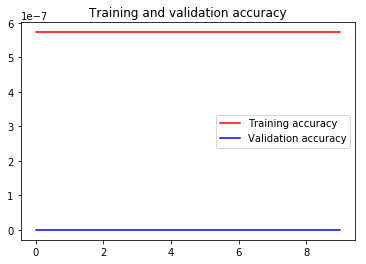

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [25]:
print(x_train[0:10])
print(y_train[0:10])


        x_0       y_0       z_0       x_1       y_1       z_1      dist  \
0  1.815638 -1.304755  0.176418  1.437101 -0.357423  0.570496  1.093630   
1  0.827092 -2.560369 -0.746174 -0.231669 -1.783008 -2.607861  2.278408   
2  0.209770 -0.111899 -2.085676  2.274343  1.113625 -1.335870  2.515269   
3  2.080155 -2.214181  0.874314  0.011347  0.036845 -0.019718  3.185338   
4  0.752653 -2.539167  1.652248  0.408675 -0.063640  0.205151  2.888018   
5 -0.611541  1.938227 -0.454997 -0.101025  1.297049  0.271152  1.095001   
6  0.891596  2.122388  0.190187 -0.658109  2.102706 -0.683145  1.778956   
7 -1.008353  1.379809 -1.131807 -0.980978  1.694856  0.625925  1.785952   
8 -0.461324  1.925866  0.938074  2.104476  0.634636  0.588600  2.893569   
9 -3.232520 -1.207658 -2.836650 -1.397085 -2.066618 -0.072233  3.427628   

     dist_x    dist_y    dist_z  dist_to_type_mean  dist_to_type_0_mean  \
0  0.143290  0.897438  0.155298           1.000667             0.463197   
1  1.120975  0.604290  3

In [26]:
predictions = model.predict(x_train[0:10])

In [27]:
predictions

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.]], dtype=float32)